In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm, feature_extraction,model_selection,metrics,linear_model
import time as time

In [5]:
spam_df = pd.read_csv('spam.csv',encoding='latin-1')

In [6]:
spam_df.head(5)
#Need to rename columns, remove last 3 rows
spam_df=spam_df.iloc[:,0:2]
spam_df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
spam_df.columns=['class','message']

In [8]:
spam_df.head(5)

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(spam_df["message"])
np.shape(X)

(5572, 8404)

In [10]:
spam_df["class"]=spam_df["class"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, spam_df["class"], test_size=0.25, random_state=20)

In [11]:
# Fit SVM
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C)) #Larger C= Lower Misclass but smaller margin
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

In [12]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.994018,0.979899,0.862434,0.987879
1,600.0,0.995453,0.981335,0.873016,0.988024
2,700.0,0.996171,0.981335,0.873016,0.988024
3,800.0,0.996650,0.982053,0.878307,0.988095
4,900.0,0.997128,0.981335,0.873016,0.988024
5,1000.0,0.997128,0.980617,0.867725,0.987952
6,1100.0,0.998086,0.981335,0.873016,0.988024
7,1200.0,0.998325,0.981335,0.873016,0.988024
8,1300.0,0.999282,0.981335,0.873016,0.988024
9,1400.0,0.999282,0.981335,0.873016,0.988024


The algorithm for svm active learning uses uncertainty sampling (concept relies on the idea behind svm).

   a) With labelled data: choose samples $x = argmin_{x} |f(x)|$
   
   b) Unlabelled data: $x = argmax_x 0.5[max(0,1-f(x))+max(0,1+f(x)]$. This formula provides maximum error. For the project, this is not used since we do not have unlabelled data. (Possible discussion point)


In [13]:
# Just taking advantage of train test split, note that test size=0.75 is intentional. 
# We will train on small test set initially, then actively learn if necessary
np.random.seed(13)
X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"], np.array(spam_df["class"]), test_size=0.25, random_state=20)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.75, random_state=20)
#Doing 2 train splits. First split seperates test data. Second split seperates train data

We will build a few basic models below to try and test the idea.

In [14]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
vocab_dict = f.fit(X_train2)
X_train2 = f.transform(X_train2)  #small start data for training
X_test2 = f.transform(X_test2)    #rest of train data
X_test = f.transform(X_test)      #the real test data

In [15]:
# Helper Functions
def closest_to_centre(X_arr,model):
    """
    Input: X_array of batch
    Output: index/indices of row of batch closest to centre. -1 if there is no such index
    """
    values = model.decision_function(X_arr)
    index = np.where((values>-1)&(values<1)) #if its outside of range, it will be properly classified
    if np.array(index).size==0:
        return np.array([])
    which_minAbs = np.where(np.abs(values[index])==np.min(np.abs(values[index])))
    return index[0][which_minAbs]

def active_learn(X_arr,y_arr,closest_index,model):
    """
    Input: X_array of batch, index of closest coordinates, model
    Output: Return the model after doing partial fitting
    """
    close = closest_index
    if (close.size==0):
        return model #Do nothing. model classifies well
    else:
        X_tofit = X_arr[close]
        y_tofit = y_arr[close]
        model.partial_fit(X_tofit,y_tofit)
        return model

def batch_learn(X_test2,y_test2,model,batch_size):
    """
    Input: X_array of the rest of the full train data
    Output: Model after training w/ active learning. Some count on how much data was used.
    """
    count = 0
    rows_used = 0
    time_start = time.time()
    while (count<X_test2.shape[0]):
        tail = np.min([X_test2.shape[0],count+batch_size])
        X_arr = X_test2[count:tail]
        y_arr = y_test2[count:tail]
        closest_index = closest_to_centre(X_arr,model)
        model = active_learn(X_arr,y_arr,closest_index,model)
        rows_used+=closest_index.size
        count += batch_size
    time_end = time.time()
    time_taken = time_end-time_start
    return model,rows_used,time_taken

In [16]:
test_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=5) #this creates a linear SVM.
test_svm.fit(X_train2,y_train2)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [17]:
# For the base test, we use the rest of the train data to check if accuracy deteoriates.
# Note that we will have much less parameters
# Since we started training on 25% of train data
test_svm2=active_learn(X_test2,y_test2,closest_to_centre(X_test2,test_svm),test_svm)

In [18]:
print(test_svm2.score(X_test2,y_test2)) #the svm works and produces a good accuracy on the rest of train set
print(test_svm2.score(X_test,y_test))  #svm works and has good accuracy on the true test set.

0.975119617225
0.974874371859


In [19]:
test_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) #this creates a linear SVM. Go over data just once
test_svm.fit(X_train2,y_train2)
test_svm2,r,t=batch_learn(X_test2,y_test2,test_svm,10)

In [20]:
print(test_svm2.score(X_test2,y_test2)) #the svm works and produces a good accuracy on the rest of train set
print(test_svm2.score(X_test,y_test))  #svm works and has good accuracy on the true test set.
print(t)
print(r+ X_train2.shape[0])
print(X_train2.shape[0]+X_test2.shape[0])
# We used about 26% of the training data for fitting while maintaining decent accuracy on the test set. 
# Raising iterations increases accuracy.

0.931100478469
0.937544867193
0.04590272903442383
1044
4179


Put it all together below:

In [21]:
test_size = np.arange(0.5,0.95,0.05)
count = 0
time_vect = np.zeros(len(test_size))
rows_vect = np.zeros(len(test_size))
score_train = np.zeros(len(test_size))
score_test = np.zeros(len(test_size))
recall_test = np.zeros(len(test_size))
precision_test = np.zeros(len(test_size))
for test in test_size:
    X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                        np.array(spam_df["class"]),
                                                                        test_size=0.25, random_state= 15)
    X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=test, random_state=15)
    f = feature_extraction.text.CountVectorizer(stop_words = 'english')
    vocab_dict = f.fit(X_train2)
    X_train2 = f.transform(X_train2)  
    X_test2 = f.transform(X_test2)    
    X_test = f.transform(X_test)      
    base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
    base_svm.fit(X_train2,y_train2)
    final_svm,r,t = batch_learn(X_test2,y_test2,base_svm,10)
    time_vect[count]=t
    rows_vect[count]=r
    score_train[count]= final_svm.score(X_test2,y_test2)
    score_test[count] = final_svm.score(X_test,y_test)
    recall_test[count] = metrics.recall_score(y_test, final_svm.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, final_svm.predict(X_test))
    count = count + 1 

In [22]:
matrix = np.matrix(np.c_[1-(test_size), time_vect,rows_vect, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['Train_size','Time','Active Learned Data','Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,Train_size,Time,Active Learned Data,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.50,0.035902,26.0,0.968421,0.965542,0.827381,0.879747
1,0.45,0.046875,45.0,0.976512,0.967696,0.791667,0.930070
2,0.40,0.047881,40.0,0.973684,0.965542,0.821429,0.884615
3,0.35,0.055843,54.0,0.974972,0.964106,0.851190,0.851190
4,0.30,0.029915,0.0,0.919002,0.909548,0.898810,0.580769
5,0.25,0.032945,0.0,0.945136,0.934673,0.791667,0.703704
6,0.20,0.036898,0.0,0.952751,0.941134,0.839286,0.719388
7,0.15,0.036902,0.0,0.951590,0.949031,0.791667,0.786982
8,0.10,0.040894,0.0,0.944444,0.941134,0.845238,0.717172


The train size refers to percentage of train data fit into the model before active learning.
We can see that the best train size seems to be about 0.35. As the train size decreases, the parameters of the model decrease as well. As a result, we observe that when the train size becomes too small, our precision suffers greatly since the model is as good as guessing which is spam and which is not. Less parameters also means less active learning due to the lower descriptive power of the svm.

For the models run above, the batch size used was fixed at 10. We will tune the batch size below while fixing train size at 0.35.

In [23]:
batch_size = np.arange(5,100,5)
count = 0
time_vect = np.zeros(len(batch_size))
rows_vect = np.zeros(len(batch_size))
score_train = np.zeros(len(batch_size))
score_test = np.zeros(len(batch_size))
recall_test = np.zeros(len(batch_size))
precision_test = np.zeros(len(batch_size))

for batch in batch_size:
    X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                        np.array(spam_df["class"]),
                                                                        test_size=0.25, random_state= 15)
    X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.65, random_state=15)
    f = feature_extraction.text.CountVectorizer(stop_words = 'english')
    vocab_dict = f.fit(X_train2)
    X_train2 = f.transform(X_train2)  
    X_test2 = f.transform(X_test2)    
    X_test = f.transform(X_test)      
    base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
    base_svm.fit(X_train2,y_train2)
    final_svm,r,t = batch_learn(X_test2,y_test2,base_svm,batch)
    time_vect[count]=t
    rows_vect[count]=r
    score_train[count]= final_svm.score(X_test2,y_test2)
    score_test[count] = final_svm.score(X_test,y_test)
    recall_test[count] = metrics.recall_score(y_test, final_svm.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, final_svm.predict(X_test))
    count = count + 1 

In [24]:
matrix = np.matrix(np.c_[batch_size, time_vect,rows_vect, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['Batch_size','Time','Active Learned Data','Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=20)

,Batch_size,Time,Active Learned Data,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,5.0,0.086764,59.0,0.974604,0.964824,0.761905,0.934307
1,10.0,0.058837,66.0,0.976813,0.961953,0.821429,0.857143
2,15.0,0.023918,0.0,0.939271,0.933238,0.892857,0.666667
3,20.0,0.014960,0.0,0.923813,0.914573,0.863095,0.601660
4,25.0,0.034906,57.0,0.971292,0.959799,0.750000,0.900000
5,30.0,0.032912,56.0,0.978285,0.970567,0.869048,0.884848
6,35.0,0.028923,53.0,0.969452,0.962670,0.791667,0.886667
7,40.0,0.006981,0.0,0.920132,0.904523,0.910714,0.564576
8,45.0,0.007978,0.0,0.935223,0.927495,0.904762,0.641350
9,50.0,0.022939,42.0,0.972396,0.962670,0.750000,0.926471


We can see that the best batch size seems to be between 25 to 35. We can pick one depending on the aim of the project.

TODO:
a) Test on other seeds.
b) Consider using TFIDF
c) Write some argument for why the active learning one is better + features
d) Show a plot of change in accuracy of model test data after each batch. Check how long it takes for convergence. ***IMPORTANT

Answers
c) The idea behind batch size active learning is that a person will not receive thousands of SMS every day. The batches simulate each "day" or time period that the algorithm is learning. The starting train size is akin to a package of spam and ham messages to initially train the model.
The amount of actively learned data as we subsequently train has a similar meaning to how much more information the algorithm needs to tune it to a specific person because individuals can receive different forms of messages. This can be used to deal with targeted advertising spam messages. A low actively learned data that is non-zero means the algorithm has gained good classification ability quickly.

Also, if the model can start off with a small set of training data, the number of parameters need for the model is low and that can mean lower storage and memory requirements. 


In [41]:
score_test

array([ 0.96482412,  0.96195262,  0.93323762,  0.91457286,  0.95979899,
        0.97056712,  0.9626705 ,  0.90452261,  0.92749462,  0.9626705 ,
        0.97272075,  0.96338837,  0.96625987,  0.90667624,  0.965542  ,
        0.91241924,  0.96913137,  0.91313711,  0.95620962])

Text(0.5,0,'Batch size')

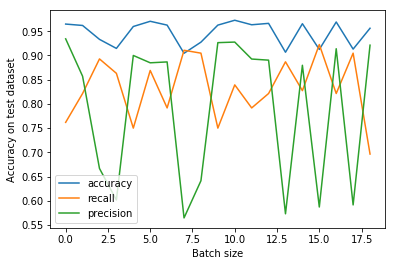

In [44]:
plt.plot(score_test,label="accuracy")
plt.plot(recall_test,label="recall")
plt.plot(precision_test,label="precision")
plt.legend()
plt.ylabel("Accuracy on test dataset")
plt.xlabel("Batch size")

The graph shows that batch size does not truly matter in this case. The final accuracy really only depends on the svm's active learning. The high fluctuation in precision observed is due to noise in the dataset, which makes it hard for the svm to tell spam from ham. However, recall values can reach 0.9, meaning we accurately determine ham messages 90% of the time. I believe this value is acceptable because of the content in sms messages. Important information will probably be sent on more secure channels such as email, so incorrectly profiling some ham messages as spam is acceptable.

Based on the information above, we pick a batch size of 30, as we feel it is a good estimate for how many SMSes a person can receive in a time period of a day while still maintaining an acceptable accuracy, precision and recall.

In [81]:
# train size 0.35, batch size =30
# code inactive learning, track accuracy.
# Helper Functions
def closest_to_centre2(X_arr,model):
    """
    Input: X_array of batch
    Output: index/indices of row of batch closest to centre. -1 if there is no such index
    """
    learning = False
    values = model.decision_function(X_arr)
    index = np.where((values>-1)&(values<1)) #if its outside of range, it will be properly classified
    if np.array(index).size==0:
        return np.array([]),learning
    learning =  True
    which_minAbs = np.where(np.abs(values[index])==np.min(np.abs(values[index])))
    return index[0][which_minAbs], learning

def batch_learn2(X_test2,y_test2,X_test,y_test,model,batch_size):
    """
    Input: X_array of the rest of the full train data. Test Data.
    Output: Model after training w/ active learning. Some count on how much data was used. 
    The accuracy array stores accuracy of the model over test data as active learnign happens.
    """
    count = 0
    rows_used = 0
    time_start = time.time()
    accuracy = []
    recall = []
    precision = []
    while (count<X_test2.shape[0]):
        tail = np.min([X_test2.shape[0],count+batch_size])
        X_arr = X_test2[count:tail]
        y_arr = y_test2[count:tail]
        closest_index,learning = closest_to_centre2(X_arr,model)
        model = active_learn(X_arr,y_arr,closest_index,model)
        rows_used+=closest_index.size
        count += batch_size
        #if learning == True:
        accuracy.append(model.score(X_test,y_test))
        recall.append(metrics.recall_score(y_test, model.predict(X_test)))
        precision.append(metrics.precision_score(y_test, model.predict(X_test)))
    time_end = time.time()
    time_taken = time_end-time_start
    return model,rows_used,time_taken,accuracy,recall,precision

In [82]:
np.random.seed(123)
batch = 30
X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                    np.array(spam_df["class"]),
                                                                    test_size=0.25, random_state= 15)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.65, random_state=15)
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
vocab_dict = f.fit(X_train2)
X_train2 = f.transform(X_train2)  
X_test2 = f.transform(X_test2)    
X_test = f.transform(X_test)      
base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
base_svm.fit(X_train2,y_train2)
final_svm,r,t,active_acc,active_recall,active_precision = batch_learn2(X_test2,y_test2,X_test,y_test,base_svm,batch)

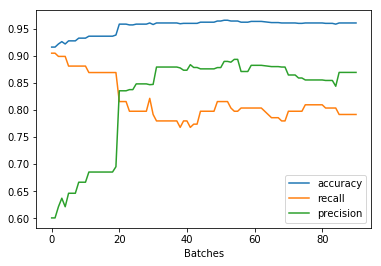

In [84]:
plt.plot(active_acc, label ="accuracy")
plt.plot(active_recall,label = "recall")
plt.plot(active_precision, label = "precision")
plt.xlabel("Batches")
plt.legend()
plt.show()

In [93]:
np.random.seed(458)
batch = 30
X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                    np.array(spam_df["class"]),
                                                                    test_size=0.25, random_state= 15)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.65, random_state=15)
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
vocab_dict = f.fit(X_train2)
X_train2 = f.transform(X_train2)  
X_test2 = f.transform(X_test2)    
X_test = f.transform(X_test)      
base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
base_svm.fit(X_train2,y_train2)
final_svm,r,t,active_acc,active_recall,active_precision = batch_learn2(X_test2,y_test2,X_test,y_test,base_svm,batch)

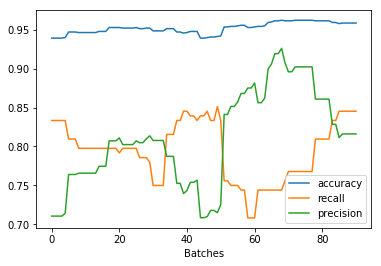

In [94]:
plt.plot(active_acc, label ="accuracy")
plt.plot(active_recall,label = "recall")
plt.plot(active_precision, label = "precision")
plt.xlabel("Batches")
plt.legend()
plt.show()

In [85]:
np.random.seed(246)
batch = 30
X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                    np.array(spam_df["class"]),
                                                                    test_size=0.25, random_state= 15)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.65, random_state=15)
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
vocab_dict = f.fit(X_train2)
X_train2 = f.transform(X_train2)  
X_test2 = f.transform(X_test2)    
X_test = f.transform(X_test)      
base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
base_svm.fit(X_train2,y_train2)
final_svm,r,t,active_acc,active_recall,active_precision = batch_learn2(X_test2,y_test2,X_test,y_test,base_svm,batch)

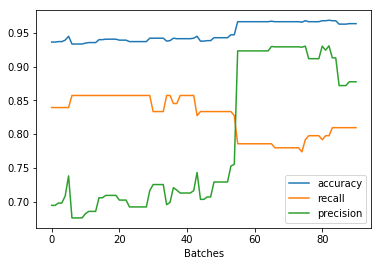

In [86]:
plt.plot(active_acc, label ="accuracy")
plt.plot(active_recall,label = "recall")
plt.plot(active_precision, label = "precision")
plt.xlabel("Batches")
plt.legend()
plt.show()

In [95]:
np.random.seed(1035)
batch = 30
X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                    np.array(spam_df["class"]),
                                                                    test_size=0.25, random_state= 15)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.65, random_state=15)
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
vocab_dict = f.fit(X_train2)
X_train2 = f.transform(X_train2)  
X_test2 = f.transform(X_test2)    
X_test = f.transform(X_test)      
base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
base_svm.fit(X_train2,y_train2)
final_svm,r,t,active_acc,active_recall,active_precision = batch_learn2(X_test2,y_test2,X_test,y_test,base_svm,batch)

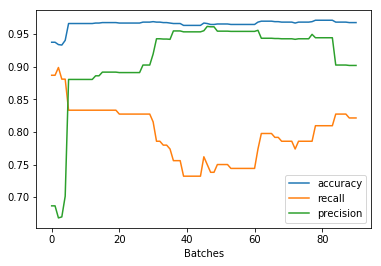

In [96]:
plt.plot(active_acc, label ="accuracy")
plt.plot(active_recall,label = "recall")
plt.plot(active_precision, label = "precision")
plt.xlabel("Batches")
plt.legend()
plt.show()

The graphs above show the metrics for accuracy, recall and precision for the model as it does active learning. The model has been initially trained on a base set consiting of 1462 rows. We then feed it batches of 30 messages until the training set is depleted.

On the graph, we can see strecthes where the metrics are a flat line. This can mean that either no active learning occurs. We can see that as the number of batches increases, accuracy and precision increases, while recall takes a slight dip. This is expected because as the svm trains itself to classify spam better, it will begin to also misclassify some ham messages as spam due to the noisy nature of SMS messages. This is because the svm we designed has fewer parameters and the parameters required to accurately classify may be out of its current parameter space.

Based on the above graphs we can see that the number of batches required for the svm to reach 80% precision and recall varies quite a lot. This is expected since in the real world, different people will receive different types of messages. It can take 20 to 80 batches, so if each batch took a day, it can take from 3 weeks to 2.5 months for the tuning to be optimal. What we can guarantee is that precision in identifying spam messages will increase at the end of the training.

Possible discussion point: Let the app have an internal cutoff for the algorithm of say 30 batches (30 days). If the misclass rate is not acceptable e.g. user flags some misclassification, the agorithm will restart for another 10 batches.


Below is a similar set of plots, but it only describes metrics when no learning occcurs. NOTE: THIS IS JUST IN CASE THE PLOTS ABOVE NOT AS INFORMATIVE. 

In [88]:
# train size 0.35, batch size =30
# code inactive learning, track accuracy.
# Helper Functions
def batch_learn3(X_test2,y_test2,X_test,y_test,model,batch_size):
    """
    Input: X_array of the rest of the full train data. Test Data.
    Output: Model after training w/ active learning. Some count on how much data was used. 
    The accuracy array stores accuracy of the model over test data as active learnign happens.
    """
    count = 0
    rows_used = 0
    time_start = time.time()
    accuracy = []
    recall = []
    precision = []
    while (count<X_test2.shape[0]):
        tail = np.min([X_test2.shape[0],count+batch_size])
        X_arr = X_test2[count:tail]
        y_arr = y_test2[count:tail]
        closest_index,learning = closest_to_centre2(X_arr,model)
        model = active_learn(X_arr,y_arr,closest_index,model)
        rows_used+=closest_index.size
        count += batch_size
        if learning == True:
            accuracy.append(model.score(X_test,y_test))
            recall.append(metrics.recall_score(y_test, model.predict(X_test)))
            precision.append(metrics.precision_score(y_test, model.predict(X_test)))
    time_end = time.time()
    time_taken = time_end-time_start
    return model,rows_used,time_taken,accuracy,recall,precision

In [89]:
np.random.seed(123)
batch = 30
X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                    np.array(spam_df["class"]),
                                                                    test_size=0.25, random_state= 15)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.65, random_state=15)
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
vocab_dict = f.fit(X_train2)
X_train2 = f.transform(X_train2)  
X_test2 = f.transform(X_test2)    
X_test = f.transform(X_test)      
base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
base_svm.fit(X_train2,y_train2)
final_svm,r,t,active_acc,active_recall,active_precision = batch_learn3(X_test2,y_test2,X_test,y_test,base_svm,batch)

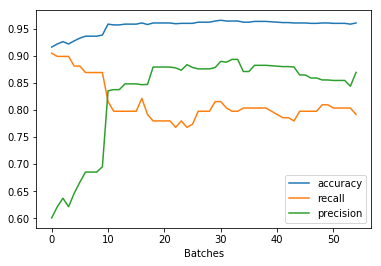

In [90]:
plt.plot(active_acc, label ="accuracy")
plt.plot(active_recall,label = "recall")
plt.plot(active_precision, label = "precision")
plt.xlabel("Active Learning")
plt.legend()
plt.show()

In [91]:
np.random.seed(246)
batch = 30
X_train, X_test, y_train, y_test = model_selection.train_test_split(spam_df["message"],
                                                                    np.array(spam_df["class"]),
                                                                    test_size=0.25, random_state= 15)
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X_train, y_train, test_size=0.65, random_state=15)
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
vocab_dict = f.fit(X_train2)
X_train2 = f.transform(X_train2)  
X_test2 = f.transform(X_test2)    
X_test = f.transform(X_test)      
base_svm = linear_model.SGDClassifier(loss="hinge",penalty="l2",max_iter=1) 
base_svm.fit(X_train2,y_train2)
final_svm,r,t,active_acc,active_recall,active_precision = batch_learn3(X_test2,y_test2,X_test,y_test,base_svm,batch)

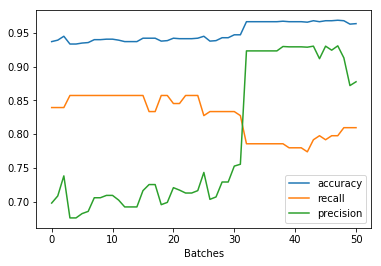

In [92]:
plt.plot(active_acc, label ="accuracy")
plt.plot(active_recall,label = "recall")
plt.plot(active_precision, label = "precision")
plt.xlabel("Active Learning")
plt.legend()
plt.show()